### 0. Import util libraries

In [1]:
import numpy as np
import torch
torch.manual_seed(123)
from scipy import interpolate
import random
from scipy.integrate import solve_ivp

# helmholtz gp imports
import helmholtz_gp.helmholtz_regression_pytorch as hrp
import helmholtz_gp.plot_helper_arxiv as plot_helm
from helmholtz_gp.parameters import TwoKernelGPParams
from helmholtz_gp.optimization_loop import basic_optimization_loop

# d-hnn imports
import dissipative_hnns
from dissipative_hnns.models import MLP, DHNN, HNN
from dissipative_hnns.train import train, get_args

# set plotting params for the notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=5)
from matplotlib import cm
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 12,
        }
    )

### 1. Import the data

In [27]:
X_grid = np.genfromtxt('../data/Xgrid_duffing_divbig.csv', delimiter=',')
Y_grid = np.genfromtxt('../data/Ygrid_duffing_divbig.csv', delimiter=',')
XY_train = torch.from_numpy(np.genfromtxt('../data/XY_train_duffing_divbig.csv', delimiter=','))
XY_test = torch.from_numpy(np.genfromtxt('../data/XY_test_duffing_divbig.csv', delimiter=','))
UV_train = torch.from_numpy(np.genfromtxt('../data/UV_train_duffing_divbig.csv', delimiter=','))
UV_test = torch.from_numpy(np.genfromtxt('../data/UV_test_duffing_divbig.csv', delimiter=','))
div_grid = np.genfromtxt('../data/divgrid_duffing_divbig.csv', delimiter=',')
vort_grid = np.genfromtxt('../data/vortgrid_duffing_divbig.csv', delimiter=',')

### 2. Visualize the data

We first visualize the imported data. In the first column we have the underlying vector field, in black, and the simulated buoys traces, in red, that we will use as training data. In the second column we plot the ground truth divergence, in this case 0 everywhere. The third column represents the ground truth vorticity, -2 everywhere. 

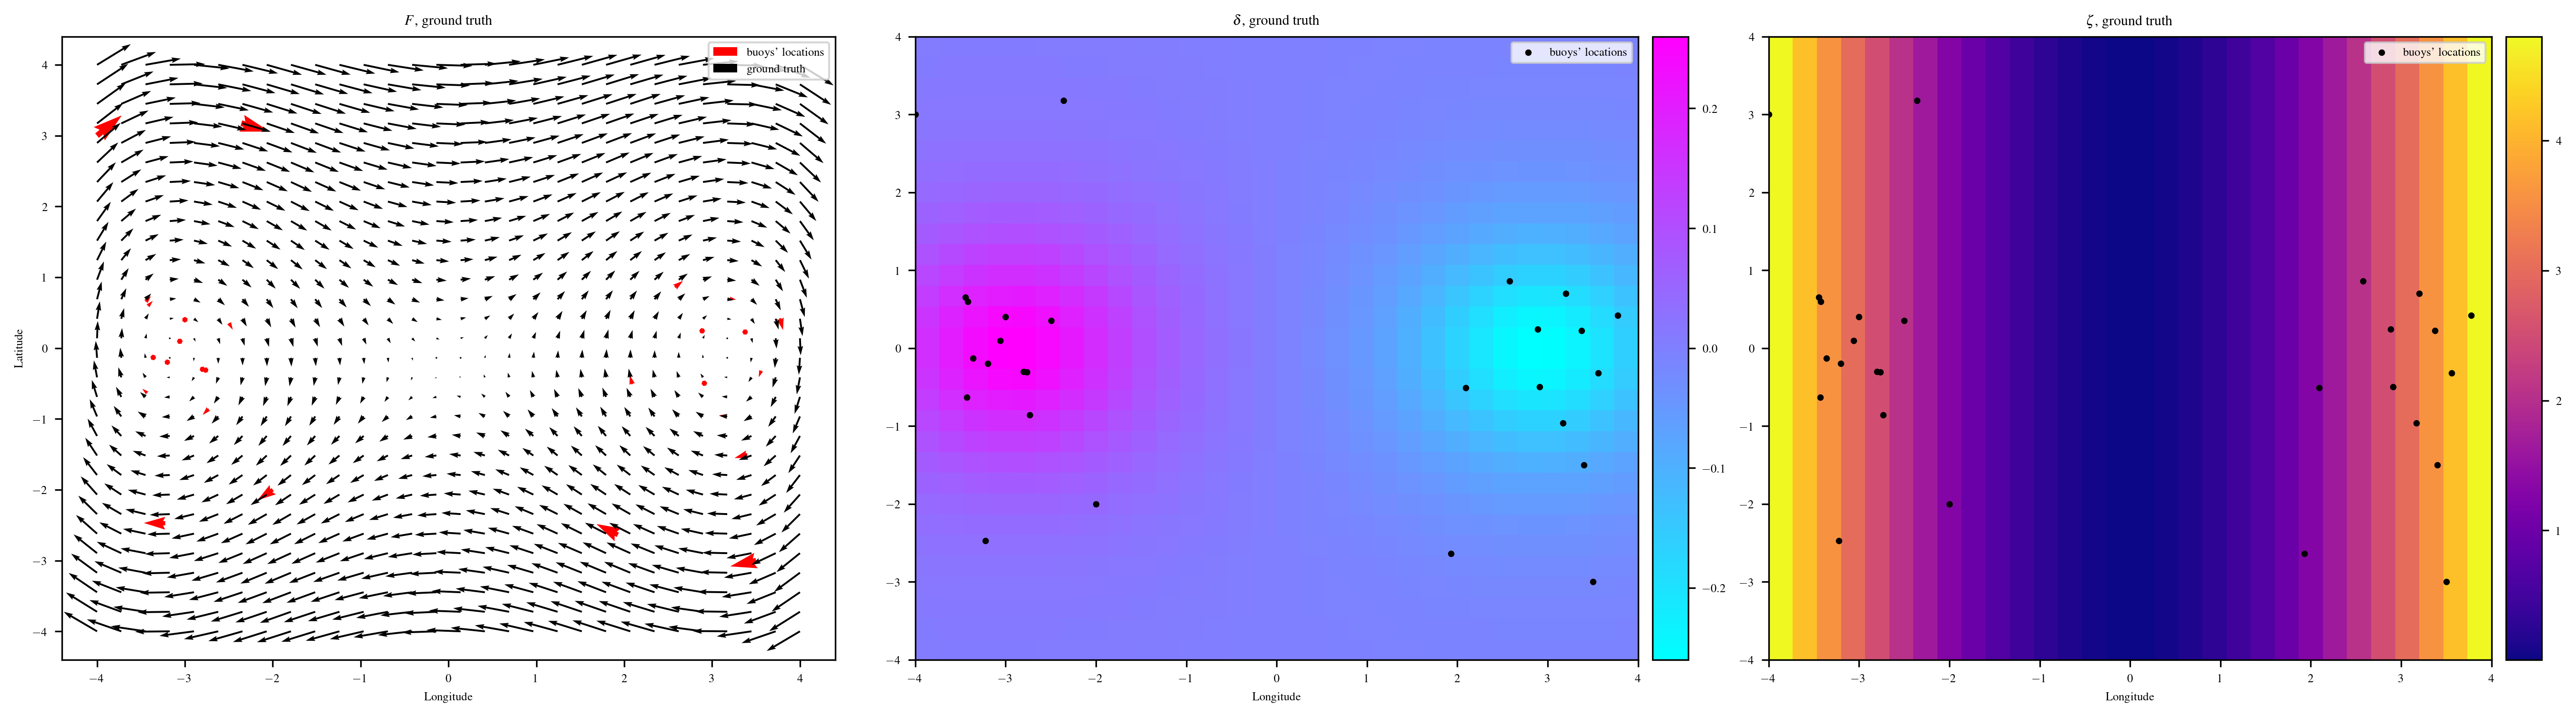

In [28]:
plot_helm.visualize_data(X_grid, Y_grid, XY_train, UV_train, XY_test, UV_test, vort_grid, div_grid, scale=10)

### 3. Fit the Helmholtz GP 

We first fit the Helmholtz GP. The parameters are optimized on the log-scale, as follows. The loss function is the negative log-likelihood of the training points. 

Optimizer for GP:

In [4]:
log_ls_Phi = torch.tensor(0., requires_grad=True) 
log_sigma_Phi = torch.tensor(0., requires_grad=True)
log_ls_A = torch.tensor(1., requires_grad=True)
log_sigma_A = torch.tensor(-1., requires_grad=True) 
log_obs_noise_helm = torch.tensor(-2., requires_grad=True)

params_helm = [log_ls_Phi,log_sigma_Phi,log_ls_A,log_sigma_A,log_obs_noise_helm]
params_helm = TwoKernelGPParams(*params_helm)

def loss_helm(params_helm):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "helmholtz", params=params_helm)[2][0,0]

In [5]:
basic_optimization_loop(loss_helm, params_helm)

At step 0, loss: 156.25689591002225
At step 100, loss: 16.860945005941208
At step 200, loss: -13.745248694139594
At step 300, loss: -39.26609041335155
At step 400, loss: -58.41055688725772
At step 500, loss: -68.72267061909506
At step 600, loss: -73.31239196199243
At step 700, loss: -74.92610047079022
At step 800, loss: -75.51217261617985
At step 900, loss: -75.78877999293921
At step 1000, loss: -75.93895566971062
At step 1100, loss: -76.02236567317705
At step 1200, loss: -76.06820278594243
At step 1300, loss: -76.09283117642443


We can show the optimal parameters:

In [6]:
best_params_helm = params_helm.get_params()
best_params_helm

[tensor(3.0224, grad_fn=<ExpBackward0>),
 tensor(0.4806, grad_fn=<ExpBackward0>),
 tensor(3.4176, grad_fn=<ExpBackward0>),
 tensor(12.3002, grad_fn=<ExpBackward0>),
 tensor(0.0139, grad_fn=<ExpBackward0>)]

We visualize the predicted mean and covariance:

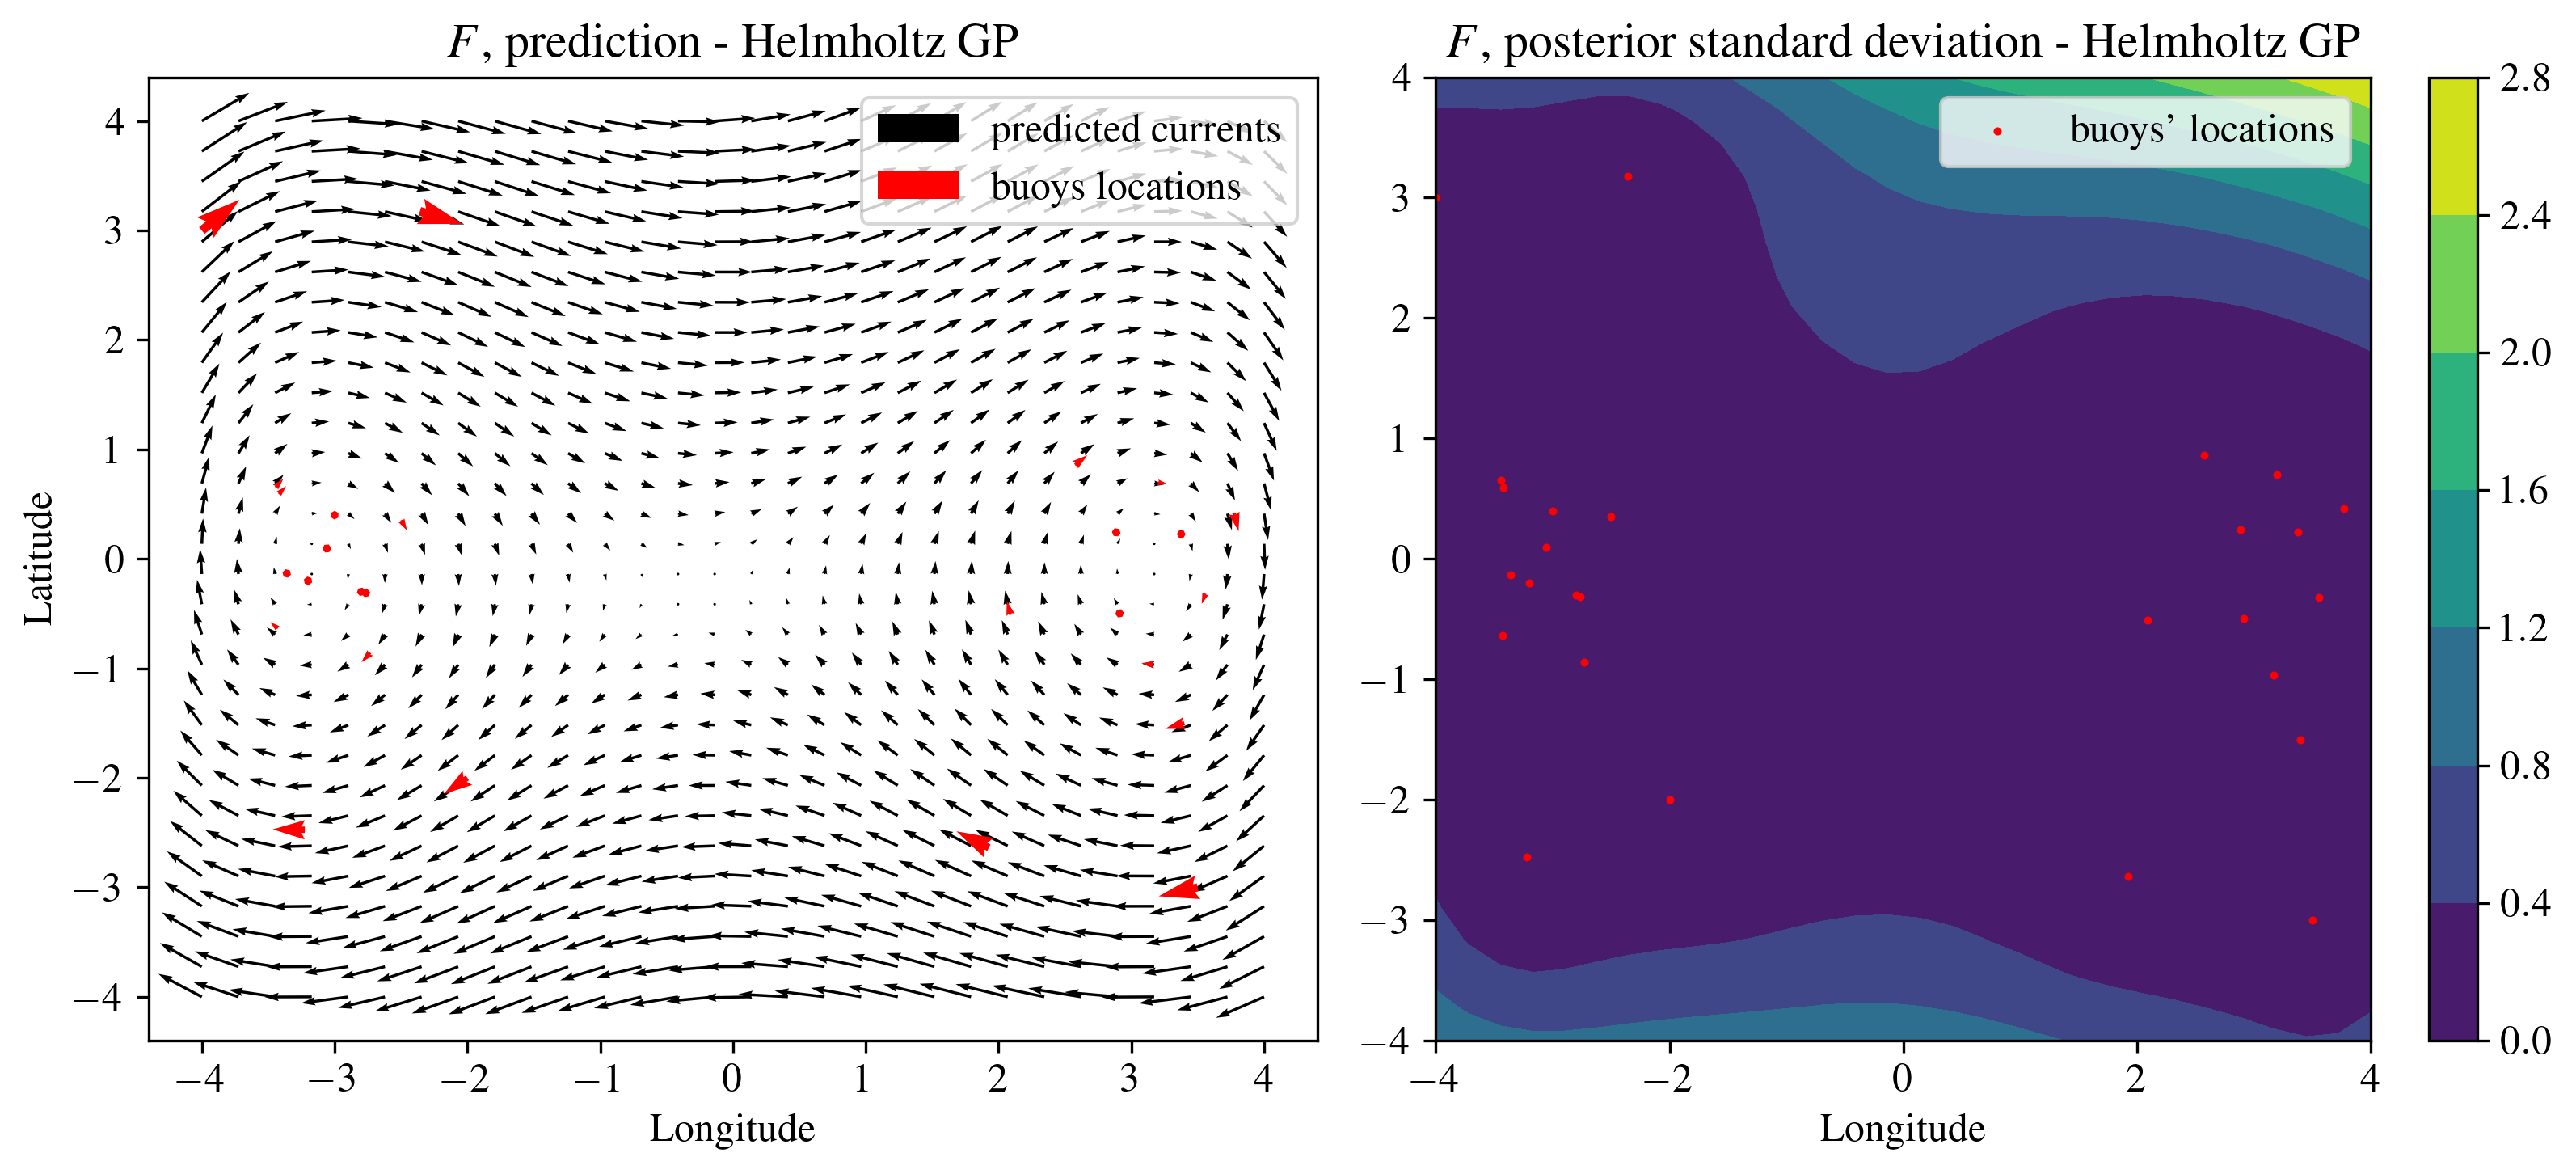

In [7]:
opt_post_mean_helm, opt_post_cov_helm, opt_ll_helm = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "helmholtz", params_helm)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_helm, opt_post_cov_helm, levels="", scale=10, method="Helmholtz GP")


### 4. Fit velocity GP regression

We then fit the velocity GP, in a similar way.

In [8]:
log_ls_u = torch.tensor(0., requires_grad=True) 
log_sigma_u = torch.tensor(0., requires_grad=True)
log_ls_v = torch.tensor(1., requires_grad=True)
log_sigma_v = torch.tensor(-1., requires_grad=True) 
log_obs_noise_uv = torch.tensor(-2., requires_grad=True)

params_uv = [log_ls_u,log_sigma_u,log_ls_v,log_sigma_v,log_obs_noise_uv]
params_uv = TwoKernelGPParams(*params_uv)

def loss_uv(params_uv):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "standard", params=params_uv)[2][0,0]

In [9]:
basic_optimization_loop(loss_uv, params_uv)

At step 0, loss: 40.79469775553342
At step 100, loss: -21.03272355707704
At step 200, loss: -44.50907161995858
At step 300, loss: -55.41573576517091
At step 400, loss: -59.74134042925894
At step 500, loss: -62.42127346969382
At step 600, loss: -64.76955407189524
At step 700, loss: -67.0268451767005
At step 800, loss: -69.34910269515817
At step 900, loss: -78.9379117658244
At step 1000, loss: -82.1481033541865
At step 1100, loss: -83.63114669598649
At step 1200, loss: -84.29403265437158
At step 1300, loss: -84.58514228195457
At step 1400, loss: -84.71074830109963
At step 1500, loss: -84.76366962324386
At step 1600, loss: -84.78526465508075


In [10]:
best_params_uv = params_uv.get_params()
best_params_uv

[tensor(9.2390, grad_fn=<ExpBackward0>),
 tensor(5.7370, grad_fn=<ExpBackward0>),
 tensor(2.7183, grad_fn=<ExpBackward0>),
 tensor(55.5962, grad_fn=<ExpBackward0>),
 tensor(0.0189, grad_fn=<ExpBackward0>)]

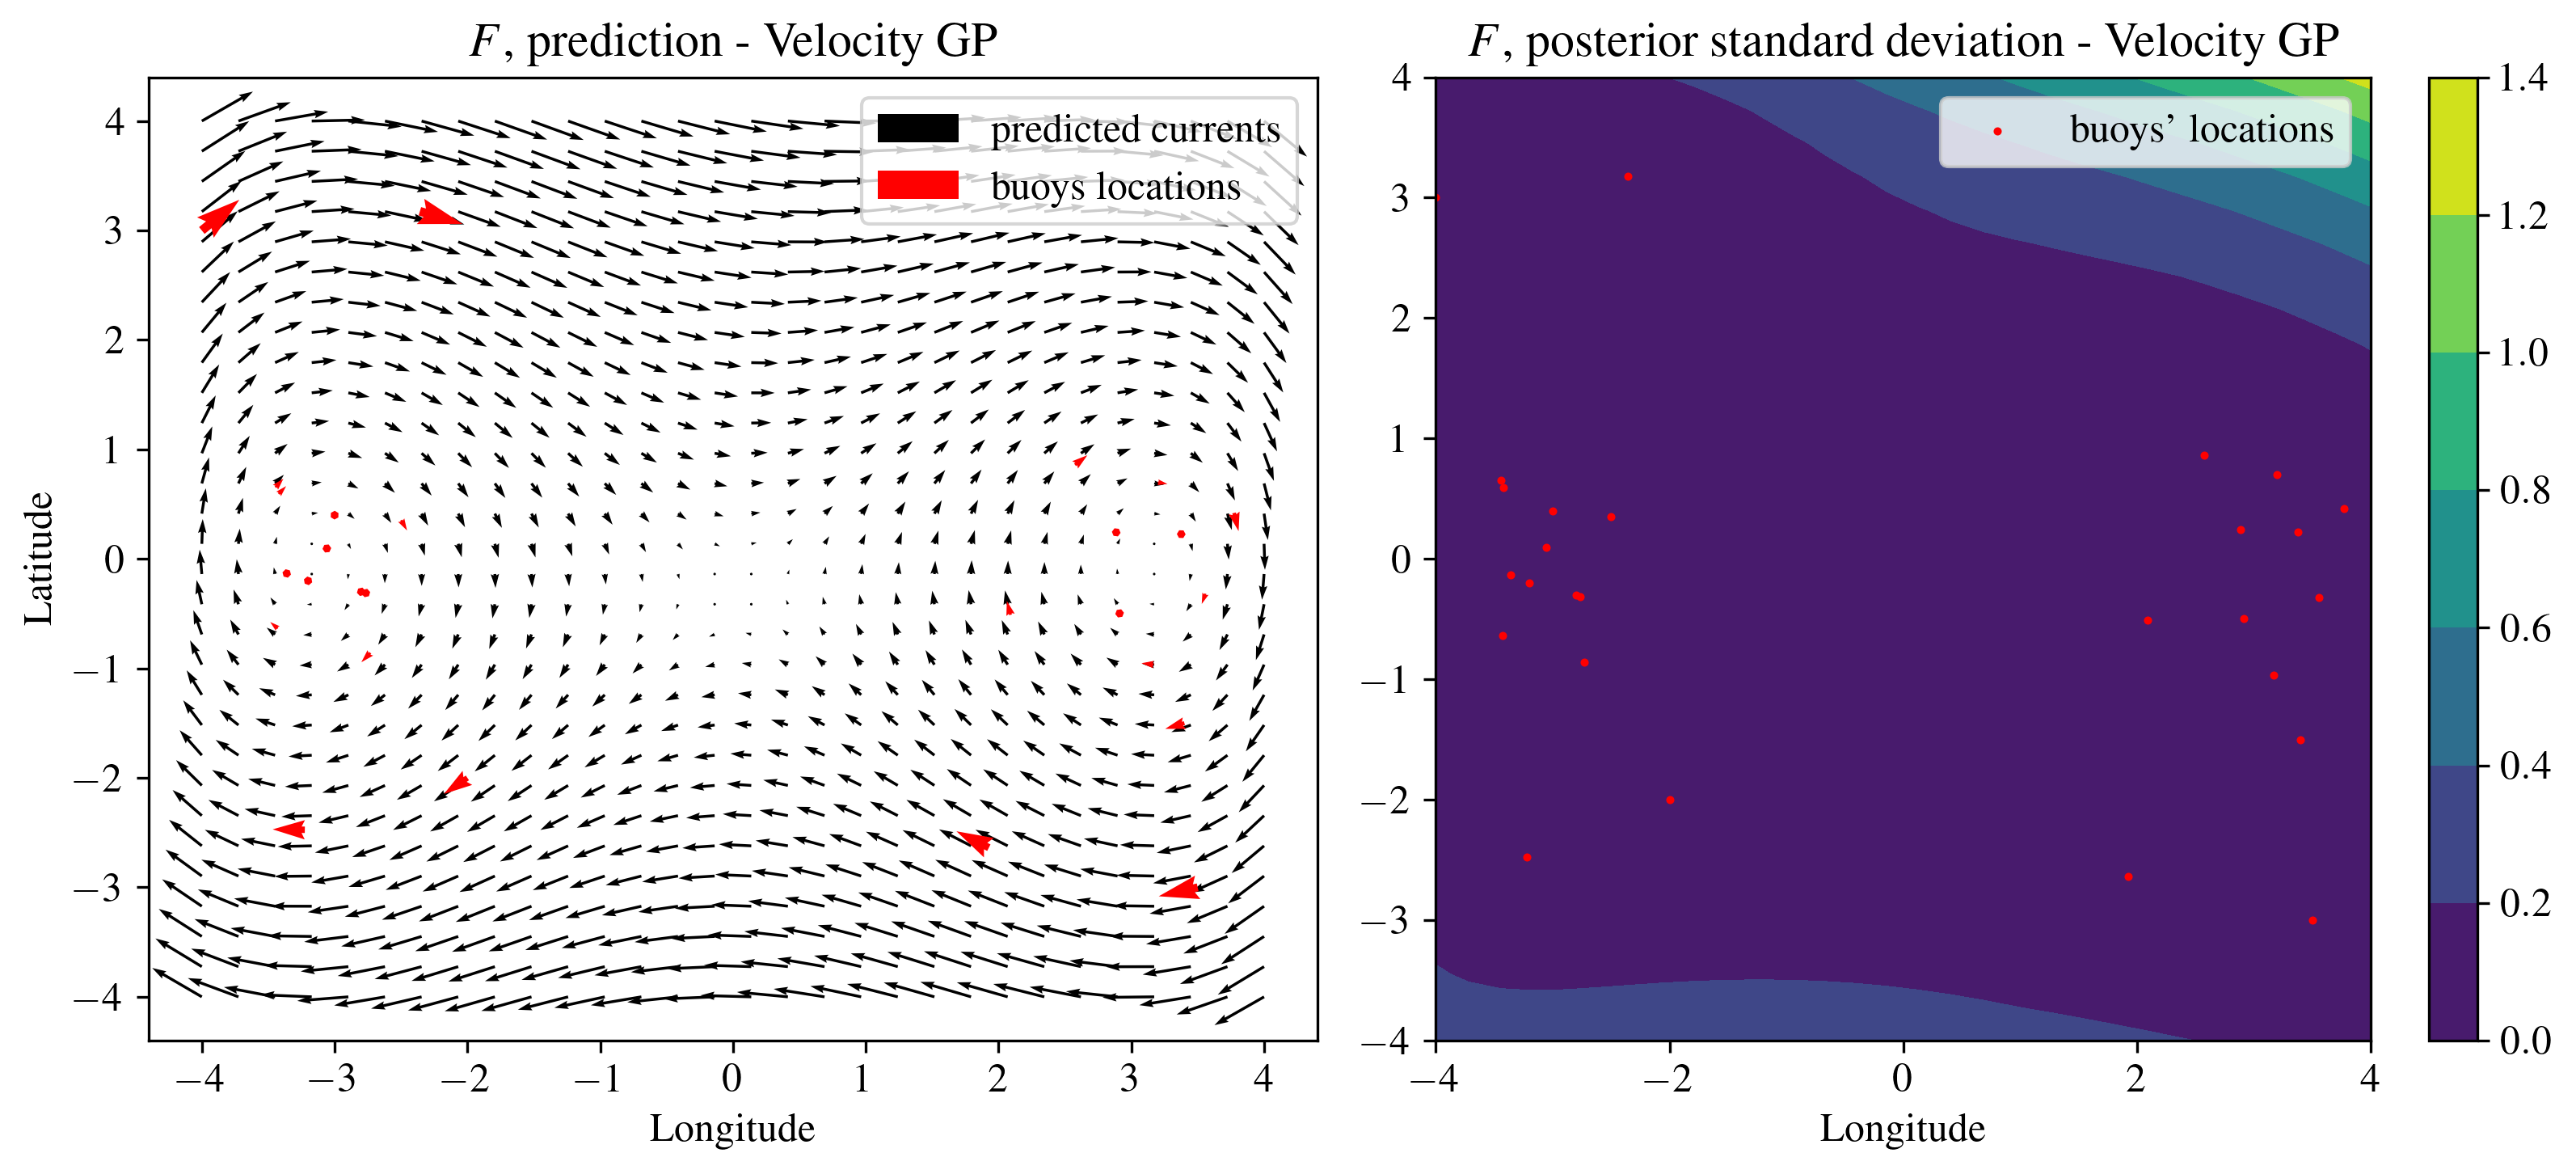

In [11]:
opt_post_mean_uv, opt_post_cov_uv, opt_ll_uv = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "standard", params_uv)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_uv, opt_post_cov_uv, levels=False, scale=10, method="Velocity GP")


### 5. Visually compare velocity field predictions

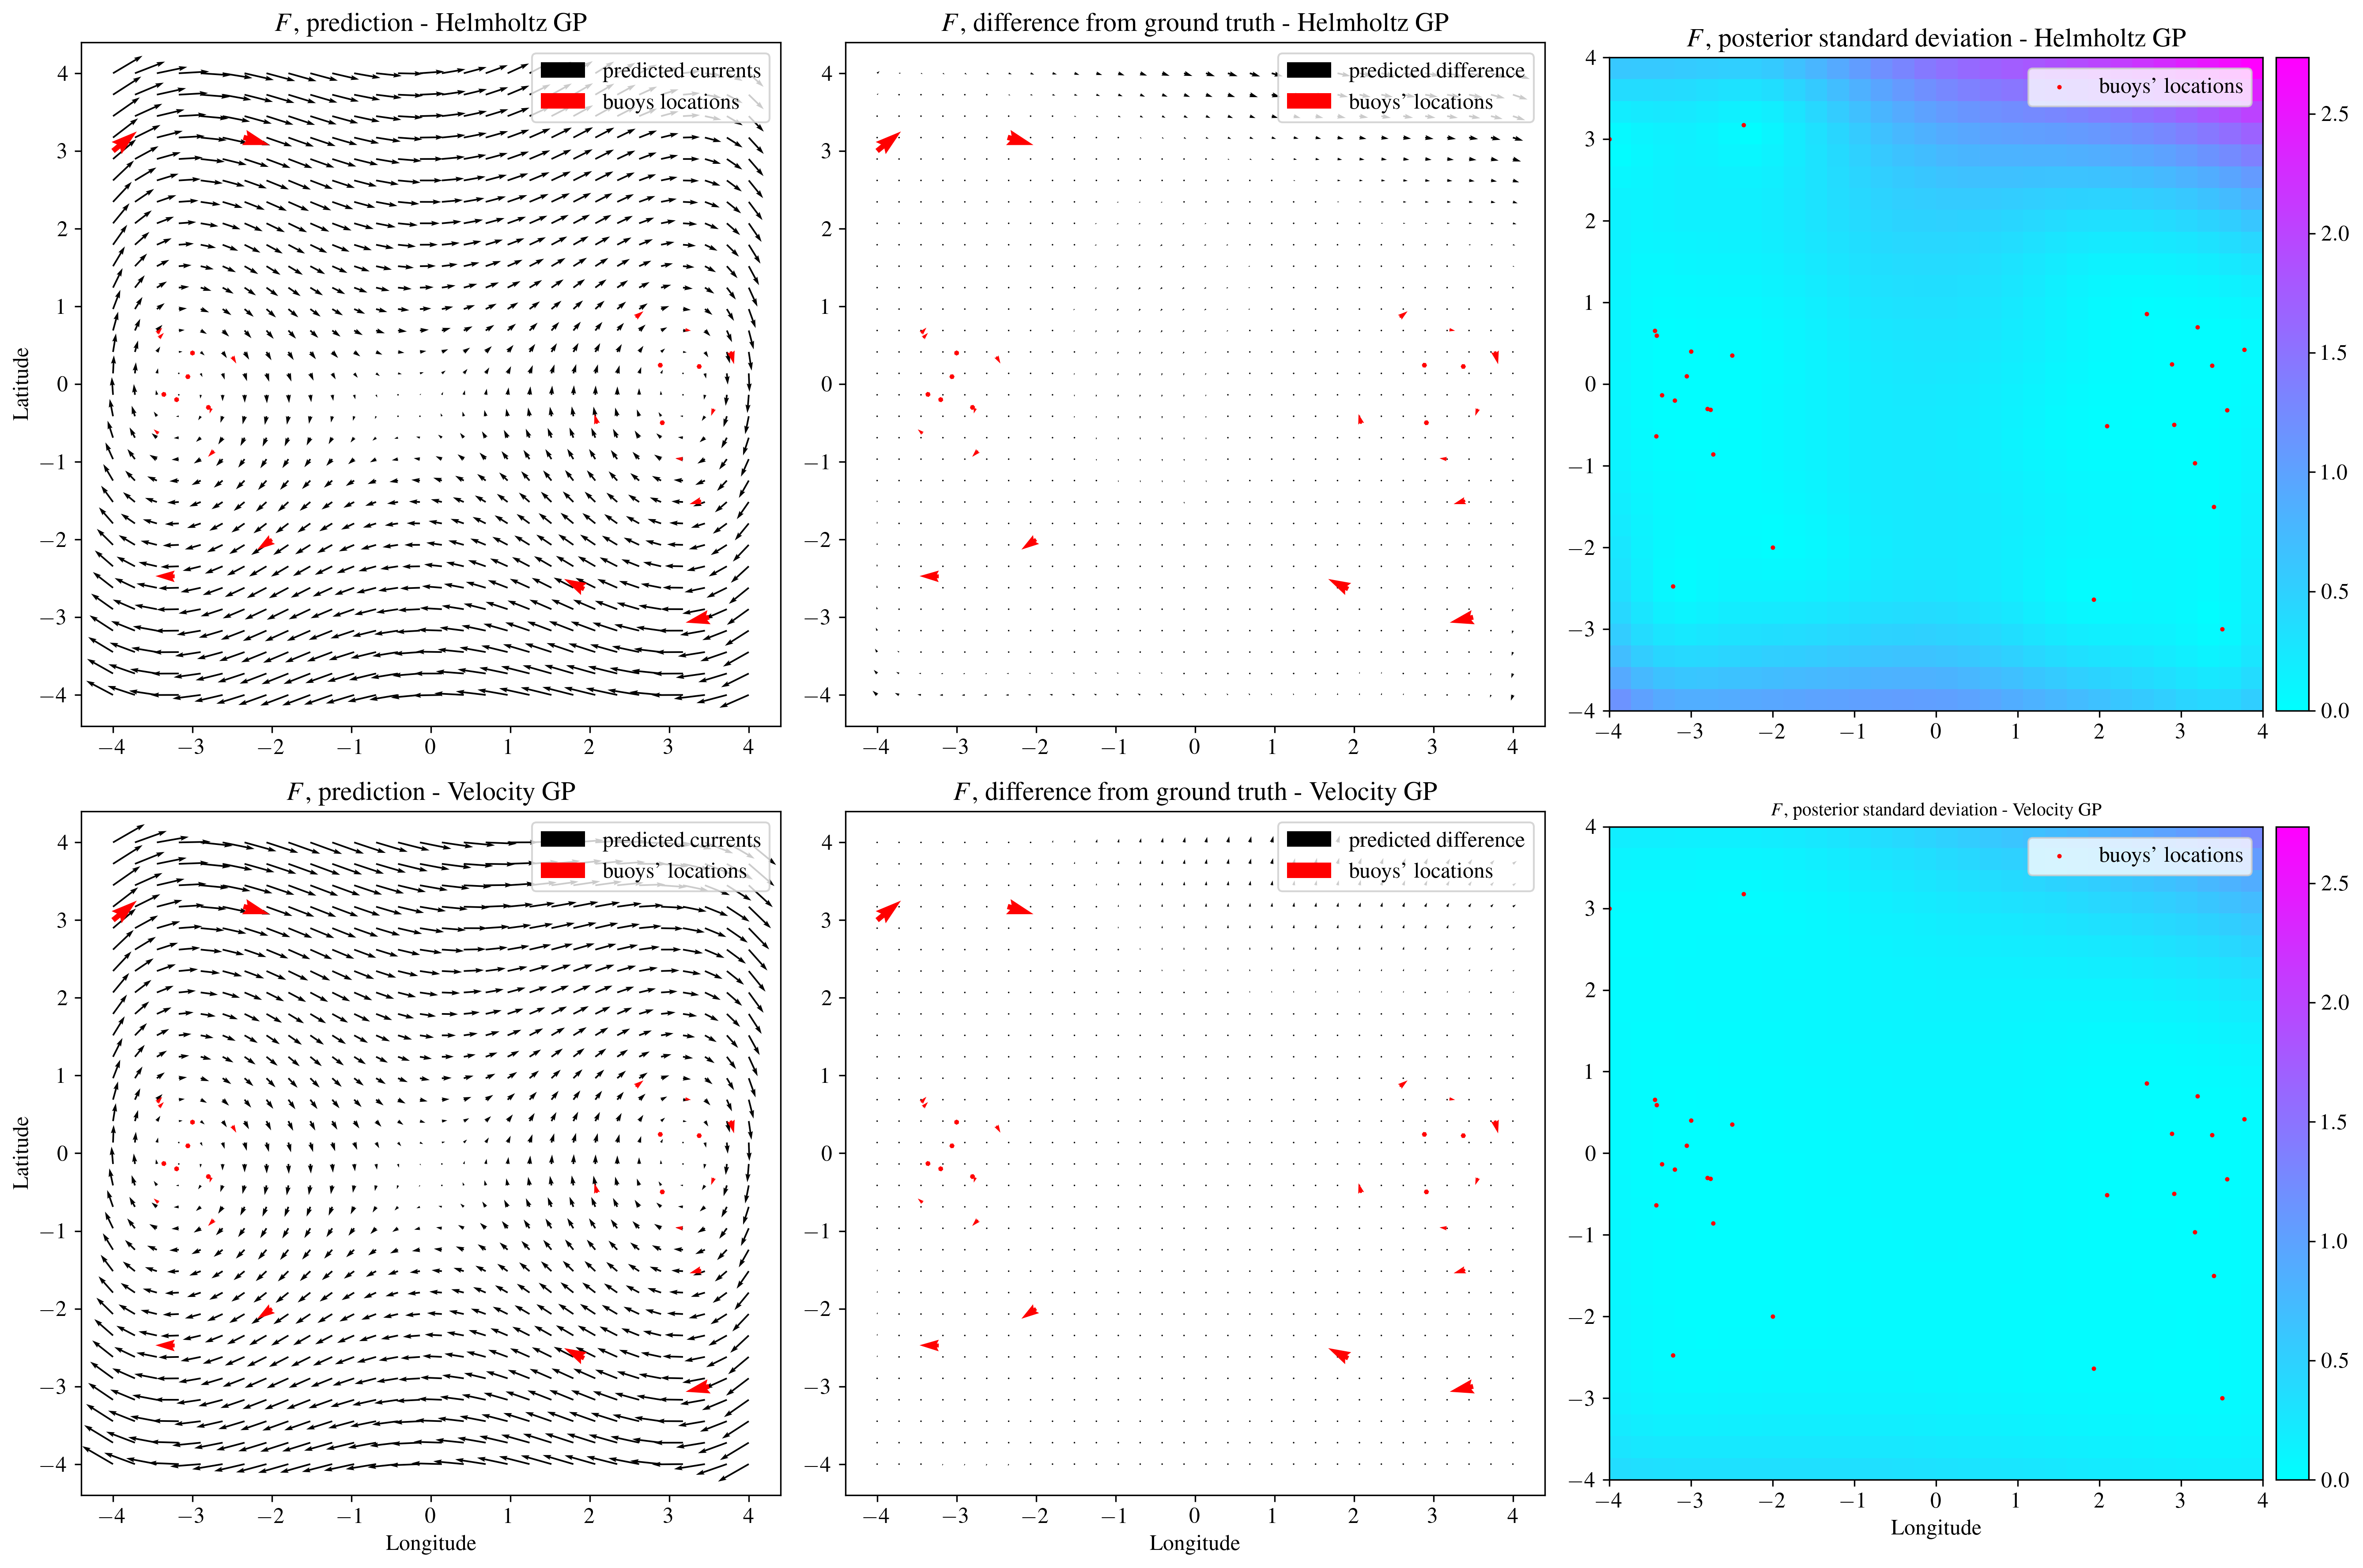

In [12]:
plot_helm.plot_results_comparison(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                                opt_post_mean_helm, opt_post_cov_helm,
                                opt_post_mean_uv, opt_post_cov_uv,
                                scale=10, cmap='cool')
                            

### 6. Posterior divergence analysis

We compute the posterior divergence for both methods, and we visually compare the predictions, uncertainty, and z-values.

In [13]:
div_mean_helm, div_var_helm = hrp.posterior_divergence_forloop_diffphi(XY_test, XY_train, UV_train, params_helm)
div_mean_std, div_var_std = hrp.posterior_divergence_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

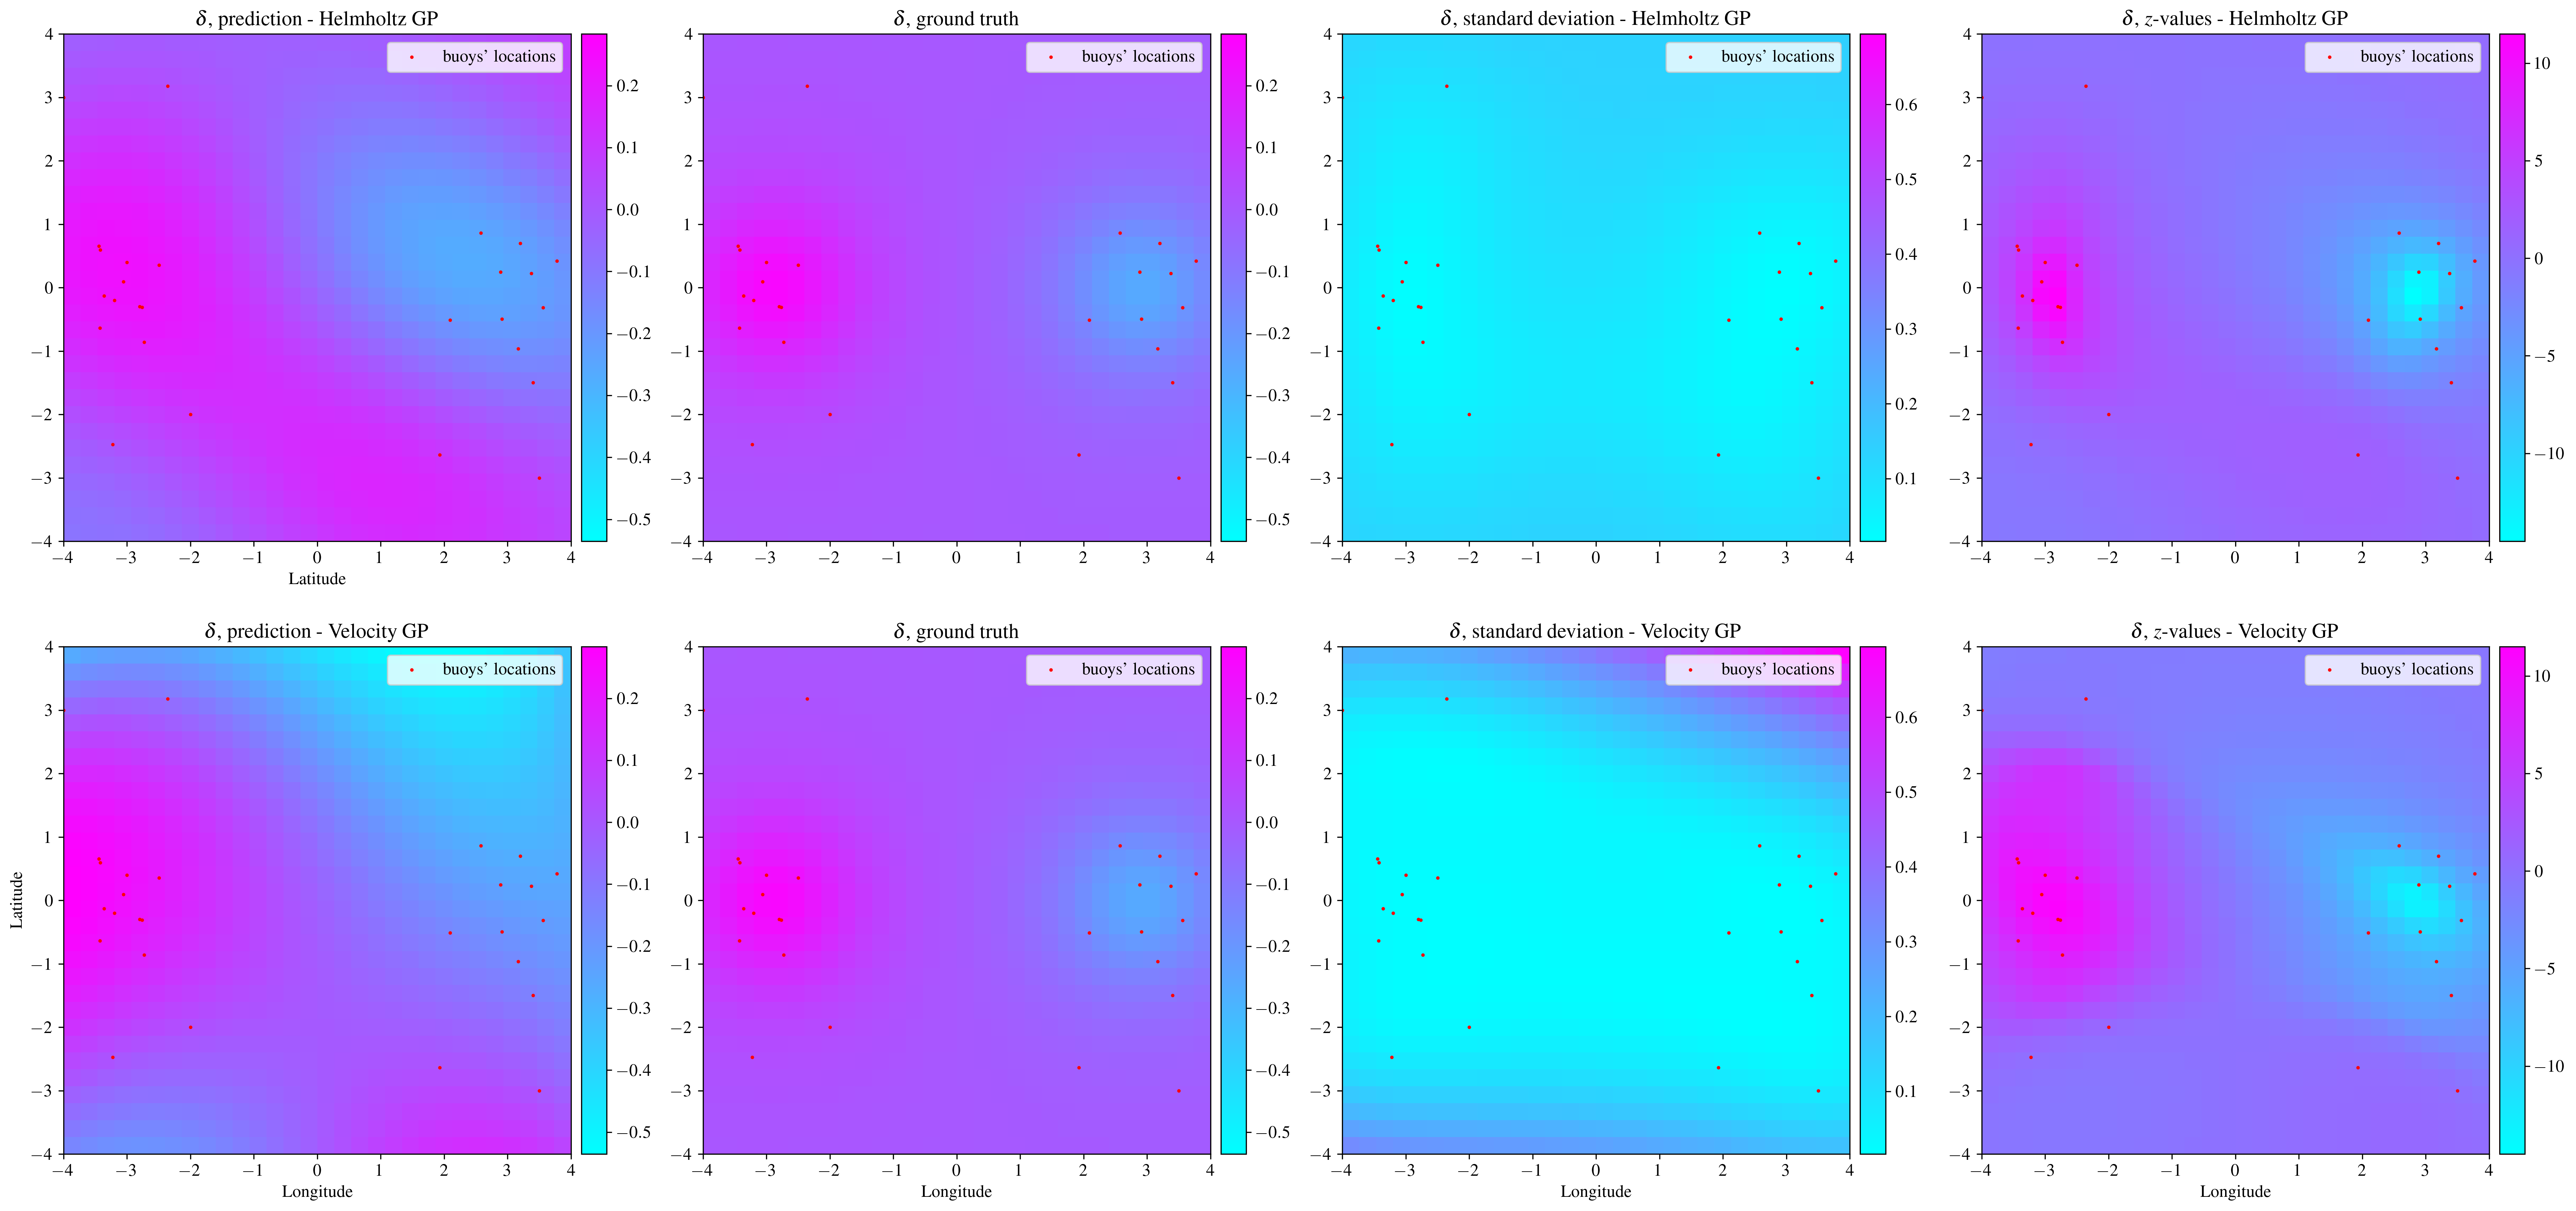

In [14]:
plot_helm.plot_scalarfield_comparison(X_grid, Y_grid, XY_train, div_grid,
                                    div_mean_helm, div_var_helm,
                                    div_mean_std, div_var_std, 
                                    component="$\delta$", cmap='cool')

### 7. Compute posterior vorticity

Similarly we compute the vorticity and plot the results.

In [15]:
vort_mean_helm, vort_var_helm = hrp.posterior_vorticity_forloop_diffpsi(XY_test, XY_train, UV_train, params_helm)
vort_mean_std, vort_var_std = hrp.posterior_vorticity_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

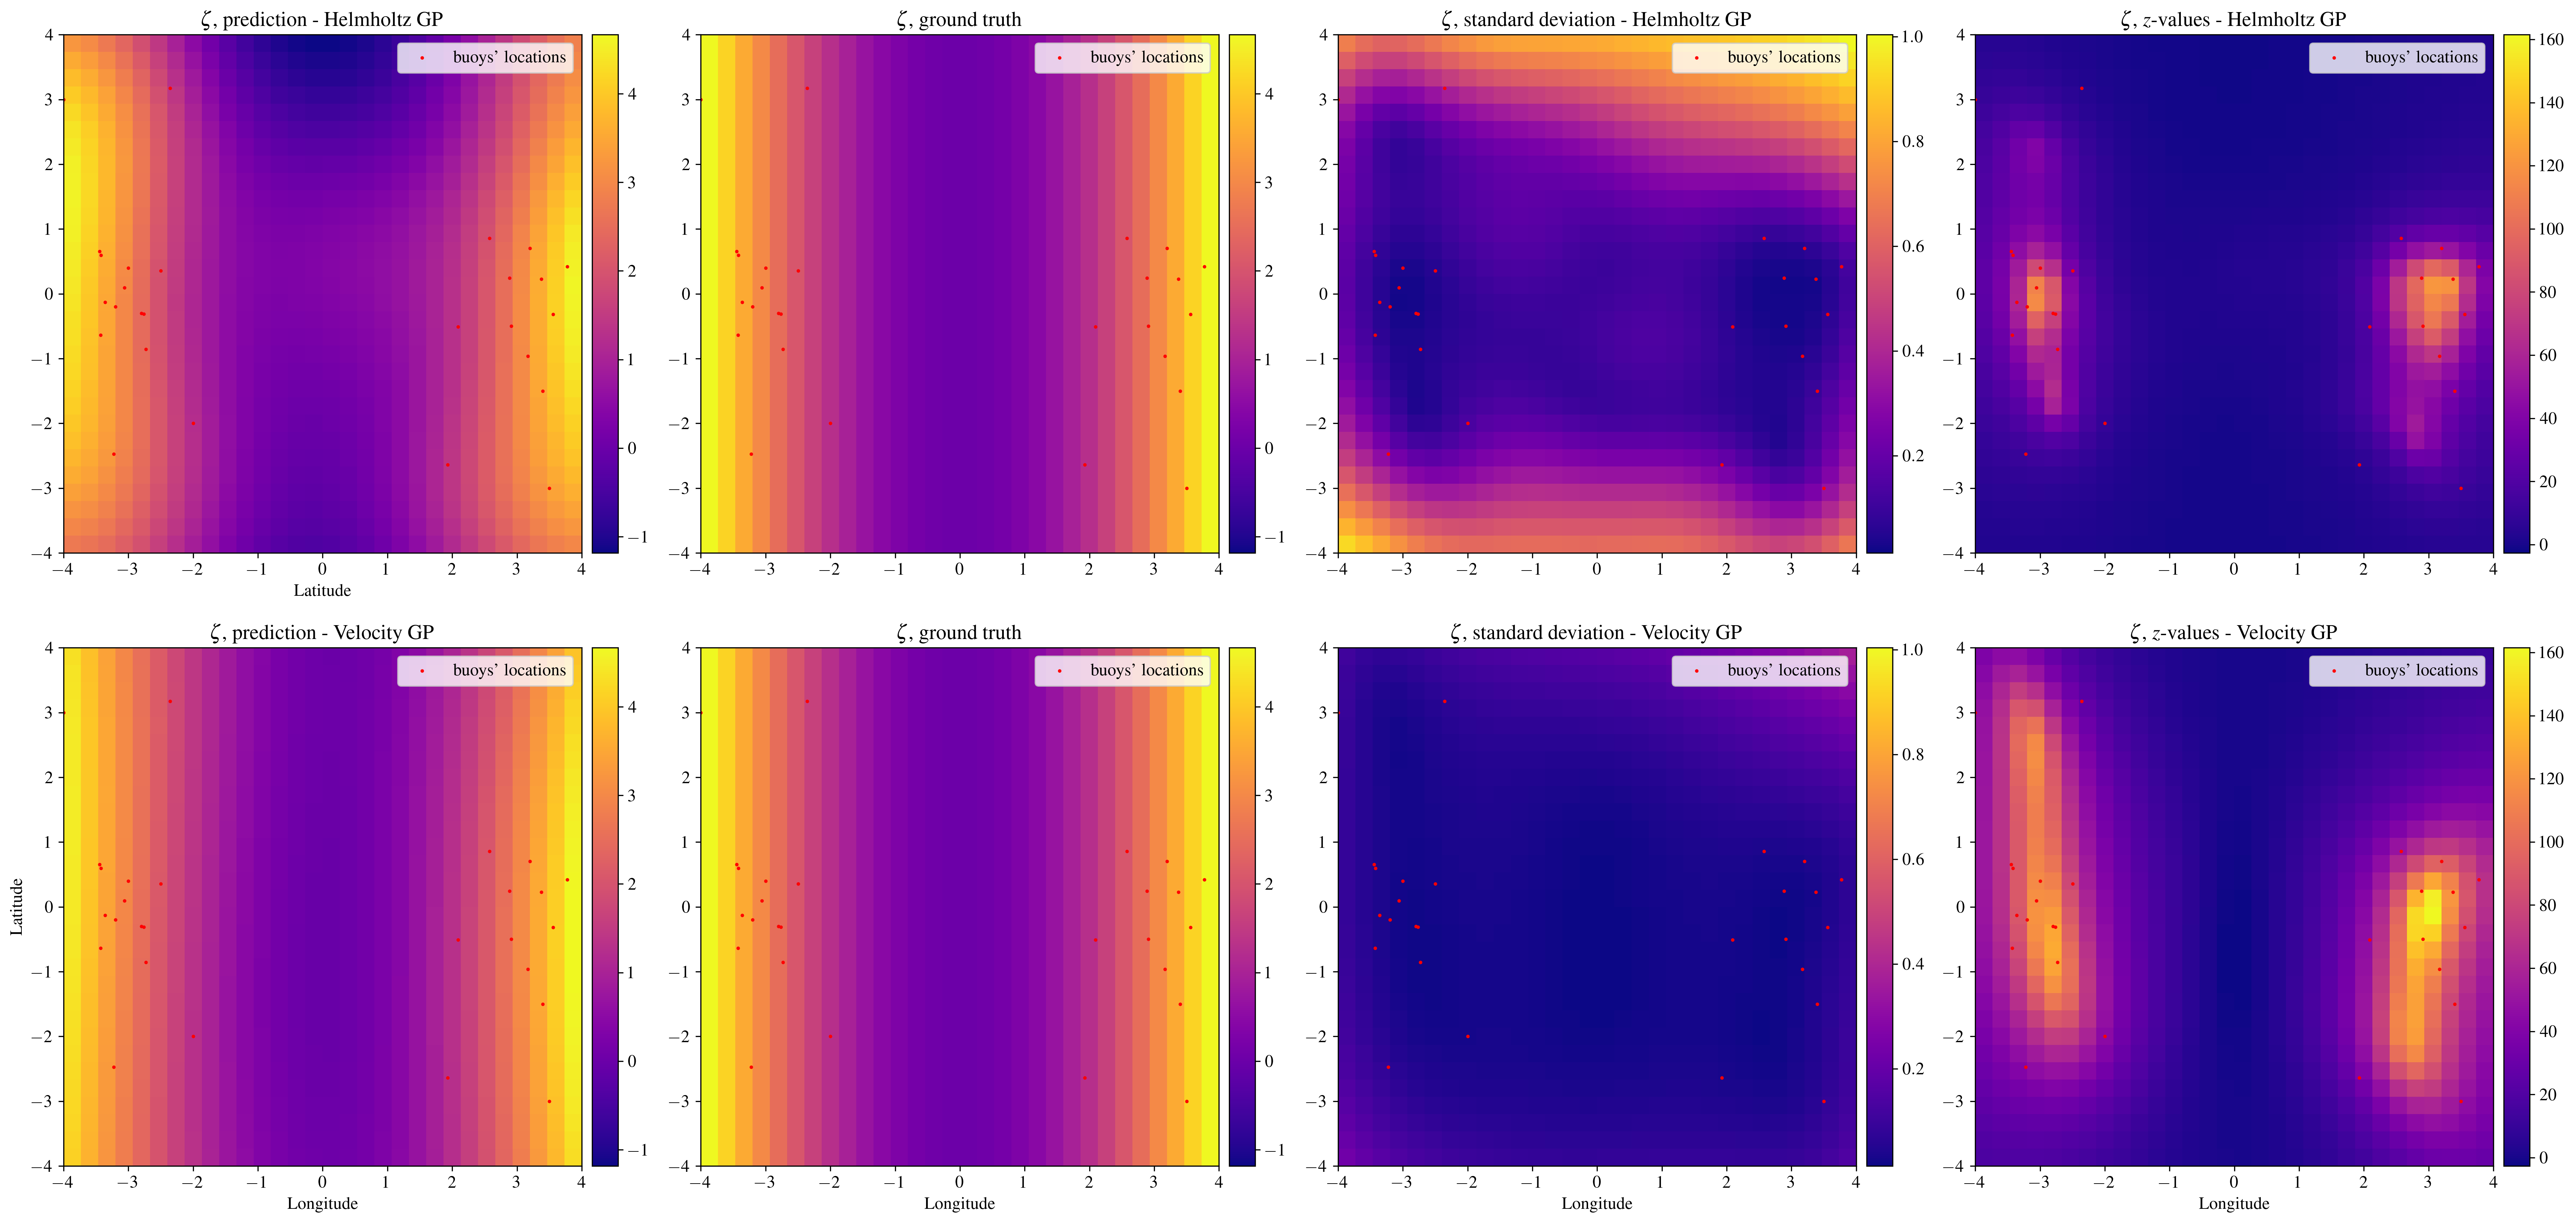

In [16]:
plot_helm.plot_scalarfield_comparison(X_grid, Y_grid, XY_train, vort_grid,
                                    vort_mean_helm, vort_var_helm,
                                    vort_mean_std, vort_var_std, 
                                    component="$\zeta$", cmap='plasma')

### 8. Get D-HNN predictions

Next, we can get the same set of results with the dissipative Hamiltonian neural network (D-HNN) approach

In [17]:
data = {'x':XY_train,
       'x_test':XY_test,
       't':np.reshape(np.ones(XY_train.shape[0]).T, [-1,1]),
       't_test':np.reshape(np.ones(XY_test.shape[0]).T, [-1,1]),
       'dx':UV_train, 
       'dx_test':UV_test
       }

In [18]:
args = get_args()
args.learning_rate = 3e-5
args.total_steps = 50000
args.eval_every = args.print_every = 1000

args.input_dim = 3
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
dhnn_model = DHNN(args.input_dim, args.hidden_dim)
dhnn_results = train(dhnn_model, args, data)  # training the model

/Users/renb/Desktop/helmholtz_torch_local/dissipative_hnns/train.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(v_batch, requires_grad=True,  dtype=torch.float32, device=args.device)


step 0, dt 0.005, train_loss 1.37e+00, test_loss 6.55e+00
step 1000, dt 4.002, train_loss 8.54e-02, test_loss 4.47e+00
step 2000, dt 3.963, train_loss 3.75e-02, test_loss 4.08e+00
step 3000, dt 3.849, train_loss 1.25e-02, test_loss 3.37e+00
step 4000, dt 3.853, train_loss 6.40e-03, test_loss 2.91e+00
step 5000, dt 4.082, train_loss 1.47e-03, test_loss 2.62e+00
step 6000, dt 3.752, train_loss 6.68e-04, test_loss 2.43e+00
step 7000, dt 3.757, train_loss 4.08e-03, test_loss 2.33e+00
step 8000, dt 3.889, train_loss 3.82e-04, test_loss 2.29e+00
step 9000, dt 3.858, train_loss 1.85e-04, test_loss 2.24e+00
step 10000, dt 3.795, train_loss 8.82e-05, test_loss 2.18e+00
step 11000, dt 3.918, train_loss 6.01e-04, test_loss 2.12e+00
step 12000, dt 3.926, train_loss 8.23e-05, test_loss 2.07e+00
step 13000, dt 3.397, train_loss 2.64e-05, test_loss 2.03e+00
step 14000, dt 4.443, train_loss 2.53e-05, test_loss 2.00e+00
step 15000, dt 6.403, train_loss 3.45e-05, test_loss 1.99e+00
step 16000, dt 5.663,

In [19]:
##Visualize results
[x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)
               for v in ['x', 'x_test','t', 't_test']]

#compute predictions at test points
y_hat_irr_test, y_hat_rot_test = dhnn_model(x_test, t=t_test, as_separate=True)
y_hat_test = y_hat_rot_test + y_hat_irr_test

#divergence at test point
divergence_x = torch.autograd.grad(y_hat_irr_test[:,0].sum(), x_test, create_graph=True)[0][:,0]
divergence_y = torch.autograd.grad(y_hat_irr_test[:,1].sum(), x_test, create_graph=True)[0][:,1]
divergence_dhnn = divergence_x + divergence_y

#vorticity at test point
vorticity_x = torch.autograd.grad(y_hat_rot_test[:,0].sum(), x_test, create_graph=True)[0][:,1]
vorticity_y = torch.autograd.grad(y_hat_rot_test[:,1].sum(), x_test, create_graph=True)[0][:,0]
vorticity_dhnn = vorticity_x - vorticity_y

/var/folders/xd/gc1qb67x67gbhkz1mmb7vbg40000gn/T/ipykernel_38266/4211146855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)


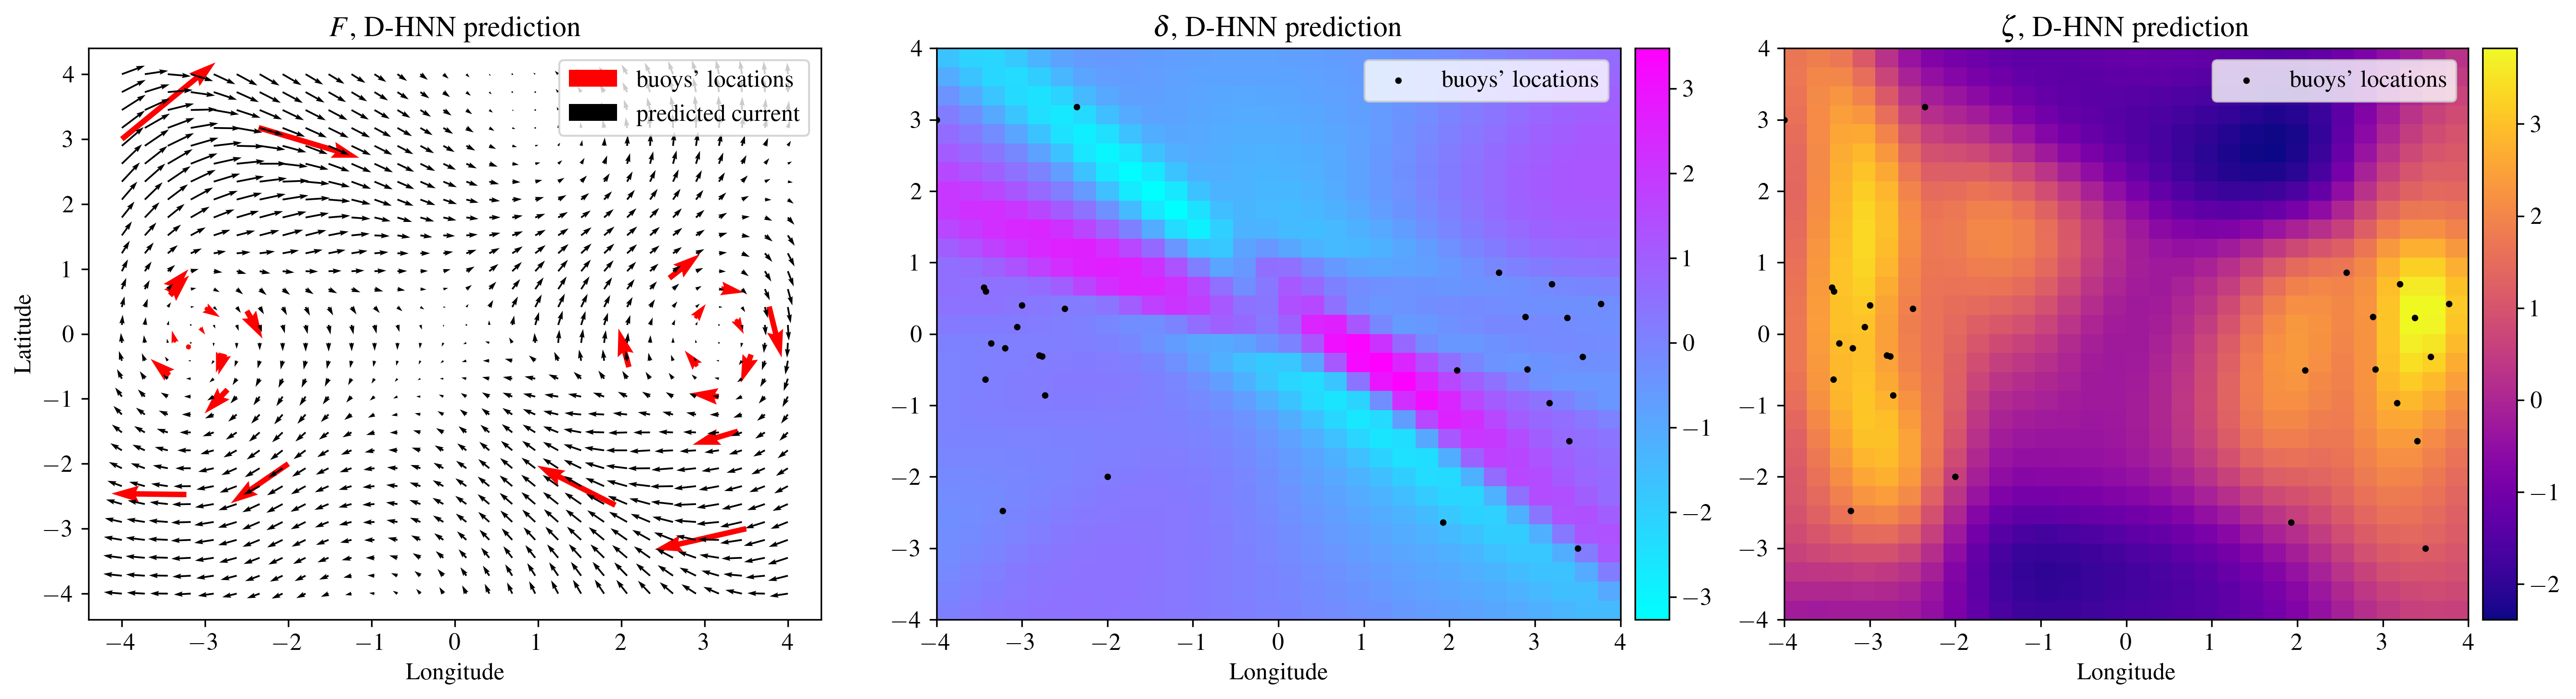

In [20]:
plot_helm.visualize_dhnn_results(X_grid, Y_grid, XY_train, UV_train, XY_test, y_hat_test, vorticity_dhnn, divergence_dhnn, cmap_div='cool', cmap_vort='plasma')

### 9. Plot for the main paper: predicted velocity field & divergence

In [21]:
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 6,
        }
    )

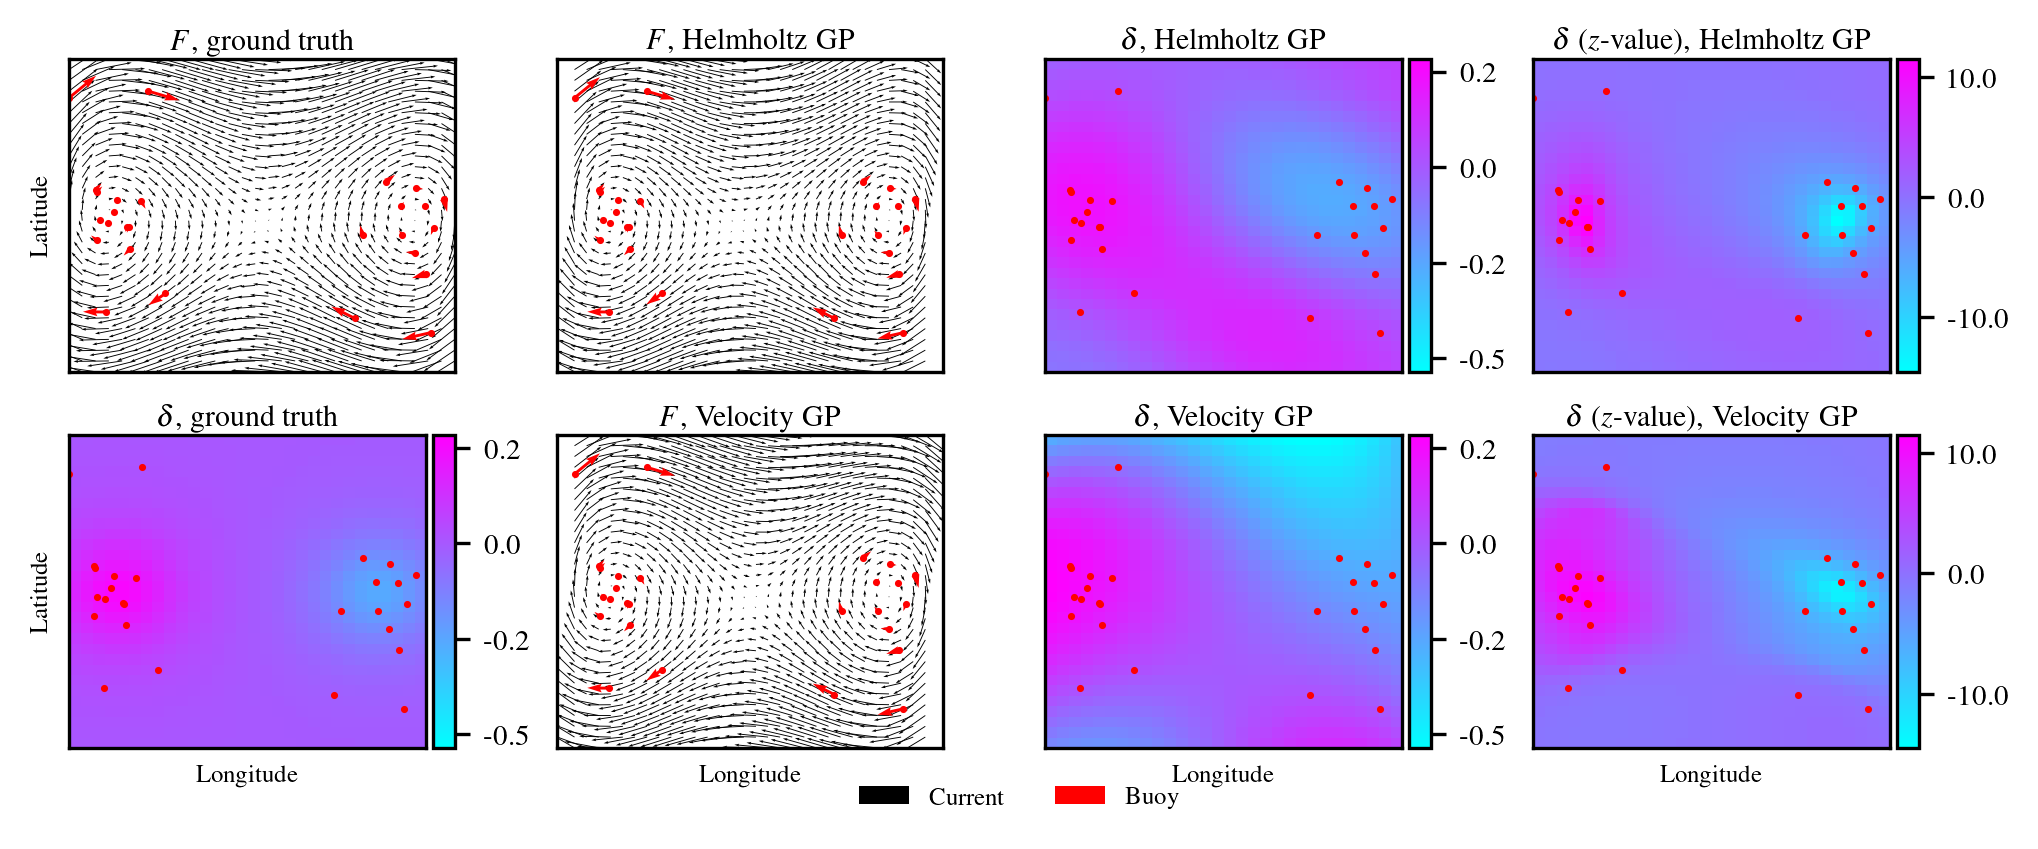

In [22]:
plot_helm.plot_results_paper(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                        opt_post_mean_helm, opt_post_cov_helm, 
                        opt_post_mean_uv, opt_post_cov_uv,
                        div_grid, 
                        div_mean_helm, div_var_helm, 
                        div_mean_std, div_var_std, cmap='cool', scale=5)

### 10. Plots for the appendix

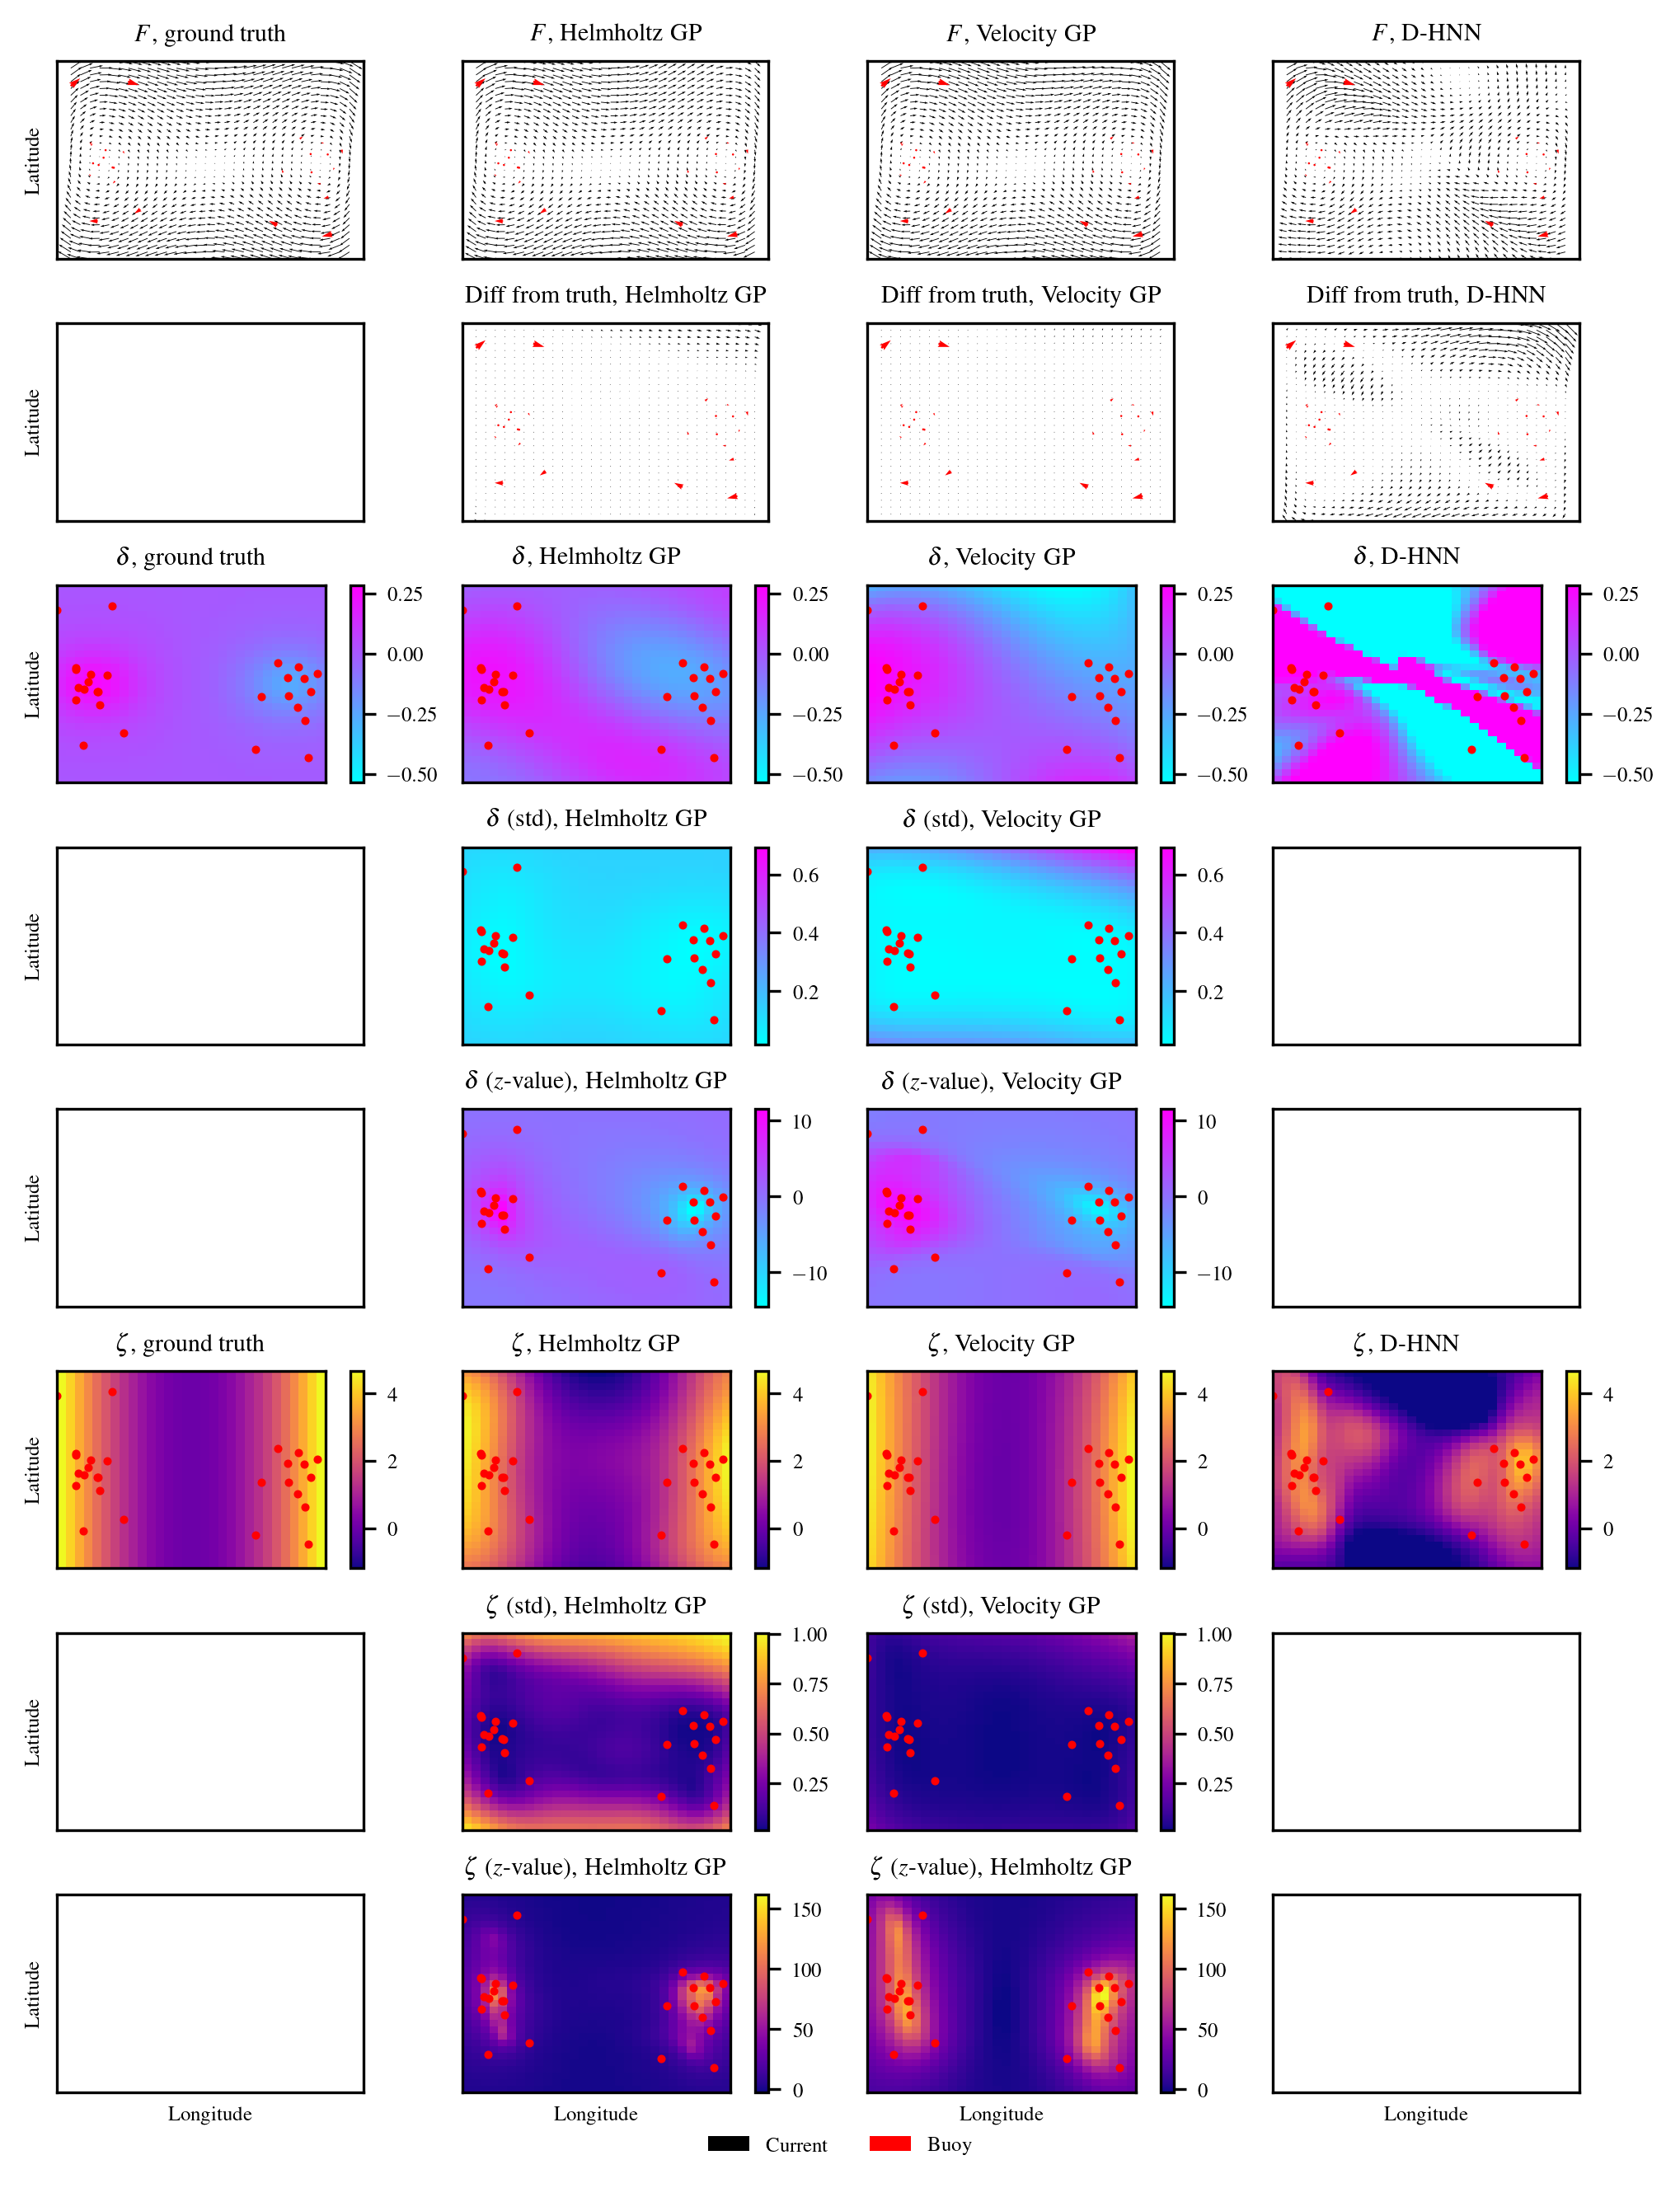

In [29]:
plot_helm.plot_results_appendix(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                        opt_post_mean_helm, opt_post_cov_helm, 
                        opt_post_mean_uv, opt_post_cov_uv, 
                        div_grid, 
                        div_mean_helm, div_var_helm, 
                        div_mean_std, div_var_std, 
                        vort_grid, 
                        vort_mean_helm, vort_var_helm, 
                        vort_mean_std, vort_var_std,
                        y_hat_test, 
                        divergence_dhnn, vorticity_dhnn, 
                        cmap='cool', cmap_vort='plasma', scale=10, save_dest = "../plots_arxiv/duffing_big_appendix")


### 11. Root Mean Squared Error (RMSE) comparison - velocity predictions

We compute mean squared error of the velocity field predictions:

In [24]:
# lambda function for the MSE
mse_velocity = lambda u_truth, v_truth, u_pred, v_pred : torch.sqrt(torch.mean((u_truth - u_pred)**2 + (v_truth - v_pred)**2))

u_truth = UV_test[:,0][:,None]
v_truth = UV_test[:,1][:,None]

#helm
u_helm = opt_post_mean_helm[:XY_test.shape[0]]
v_helm = opt_post_mean_helm[XY_test.shape[0]:]
mse_helm = mse_velocity(u_truth, v_truth, u_helm, v_helm)

#standard
u_std = opt_post_mean_uv[:XY_test.shape[0]]
v_std = opt_post_mean_uv[XY_test.shape[0]:]
mse_std = mse_velocity(u_truth, v_truth, u_std, v_std)

#d-hnn
u_dhnn = y_hat_test[:,0][:,None]
v_dhnn = y_hat_test[:,1][:,None]
mse_dhnn = mse_velocity(u_truth, v_truth, u_dhnn, v_dhnn)

print(f"Helm: {mse_helm} \nStandard: {mse_std} \nD-HNN: {mse_dhnn}")


Helm: 0.4128854454485931 
Standard: 0.22615812039596317 
D-HNN: 1.6260728873142027


### 12. RMSE comparison - divergence / vorticity

In [25]:
mse_div_vort = lambda truth, pred : torch.sqrt(torch.mean((truth-pred)**2))

div_grid = torch.flatten(torch.from_numpy(div_grid))[:,None]
vort_grid = torch.flatten(torch.from_numpy(vort_grid))[:,None]

#divergence
mse_helm_div = mse_div_vort(div_grid,div_mean_helm)
mse_std_div = mse_div_vort(div_grid,div_mean_std)
div_dhnn = divergence_dhnn.flatten()
mse_dhnn_div = mse_div_vort(div_grid,div_dhnn)

#vorticity
mse_helm_vort = mse_div_vort(vort_grid,vort_mean_helm)
mse_std_vort = mse_div_vort(vort_grid,vort_mean_std)
vort_dhnn = vorticity_dhnn.flatten()
mse_dhnn_vort = mse_div_vort(vort_grid,vort_dhnn)

print(f"DIVERGENCE ---\nHelm: {mse_helm_div} \nStandard: {mse_std_div} \nD-HNN: {mse_dhnn_div}")
print(f"VORTICITY ---\nHelm: {mse_helm_vort} \nStandard: {mse_std_vort} \nD-HNN: {mse_dhnn_vort}")


DIVERGENCE ---
Helm: 0.07740846484362879 
Standard: 0.1680412032681466 
D-HNN: 1.1042987467081073
VORTICITY ---
Helm: 0.48342135630739314 
Standard: 0.16181174308221907 
D-HNN: 2.4134193533533286
